青汁
酵素
酢・黒酢
グルコサミン
プラセンタ
コラーゲン・ヒアルロン酸
乳酸菌（便秘関連）
にんにく
消臭
お茶
その他健康食品
精力剤・精力サプリ
葉酸・妊活
ダイエットサプリ
DHA・EPA
オルニチン・しじみ
キッズサプリ
筋肉サプリ・プロテイン

被引用すうもスクレイピングしてインパクトファクターを計算する。

テキストマイニングではエビデンスに基づくであろうワードを集計
政府の機構の承認。
栄養機能食品
特別用途食品
特定保健用食品：消費者庁
ロハコ

[Scientific Journal Rankings](https://www.scimagojr.com/journalrank.php)で食品分野のジャーナルのインパクトファクターを調べた。



[メルカリのコード](https://www.kaggle.com/thykhuely/mercari-interactive-eda-topic-modelling)を参考にデータ解析を行う。
メルカリの場合のdfは
name:str, condition:int,     category:str(3 categories), brand_name: str, price:float, shipping:0or1, description: str
今回のdfは
title:str,rank:int, url:str, search words(3 words):str, n_aff_url:int, n_journal_url:int, if_score:float, passage of html: str 
もしくは
search_words:str                                     n_aff_url:int, n_journal_url:int, if_score:float, passage of html: str 

In [1]:
# function definition.
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
# import lda

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
# from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.tools as tls
%matplotlib inline

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)
from bs4 import BeautifulSoup
import re
import requests
import pandas as pd
import pickle
# from google.colab import files

In [2]:
# colluct journal urls from SJR.
html_doc = requests.get('https://www.scimagojr.com/journalrank.php?area=1100&category=1106').text
soup = BeautifulSoup(html_doc, 'html.parser')
tags = soup.select("a")
url_list = []
journal_urls = []

# # introduction pages of each journals
# pages = [x.get("href") for x in tags if "journalsearch.php?q=" in x.get("href")]

# docs = [BeautifulSoup(requests.get("https://www.scimagojr.com/" + x).text, 'html.parser').select("a") for x in pages]
# docs

counter = 0

for i in [x.get("href") for x in tags if "journalsearch.php?q=" in x.get("href")]:
    doc = requests.get("https://www.scimagojr.com/" + i).text
    soup = BeautifulSoup(doc, 'html.parser')
    tags = soup.select("a")
    try:
        journal_url = [requests.get(x.get("href")).url for x in tags if x.string=="Homepage"]
        if journal_url==[]:
            journal_url = [""]
        journal_urls = journal_urls + journal_url
        print(counter)    
        print(journal_urls)
    except:
        journal_urls = journal_urls + journal_url
        print("connection error.")
        print(counter)    
        print(journal_urls)
    counter += 1

# print(journal_urls)    

# save journal_urls to txt file
f = open('journal_urls.txt', 'wb')
pickle.dump(journal_urls, f)
f = open("./journal_urls.txt","rb")
journal_urls = pickle.load(f)

0
['https://onlinelibrary.wiley.com/']
1
['https://onlinelibrary.wiley.com/', '']
2
['https://onlinelibrary.wiley.com/', '', 'https://www.elsevier.com/journals/trends-in-food-science-and-technology/0924-2244#description']
3
['https://onlinelibrary.wiley.com/', '', 'https://www.elsevier.com/journals/trends-in-food-science-and-technology/0924-2244#description', '']
4
['https://onlinelibrary.wiley.com/', '', 'https://www.elsevier.com/journals/trends-in-food-science-and-technology/0924-2244#description', '', 'https://www.elsevier.com/journals/food-hydrocolloids/0268-005X#description']
5
['https://onlinelibrary.wiley.com/', '', 'https://www.elsevier.com/journals/trends-in-food-science-and-technology/0924-2244#description', '', 'https://www.elsevier.com/journals/food-hydrocolloids/0268-005X#description', 'https://www.elsevier.com/journals/food-policy/0306-9192#description']
6
['https://onlinelibrary.wiley.com/', '', 'https://www.elsevier.com/journals/trends-in-food-science-and-technology/092

In [3]:
# make df of journal urls and impact factor scores.
html_doc = requests.get('https://www.scimagojr.com/journalrank.php?area=1100&category=1106').text
soup = BeautifulSoup(html_doc, 'html.parser')
journal_titles = [i.text for i in soup.find_all('a', title='view journal details')]
journal_scores = [i.text.split()[0] for i in soup.find_all('td', class_='orde')]

df = pd.DataFrame({'journal_titles': journal_titles, 'journal_urls': journal_urls, 'journal_scores': journal_scores})

# create 'simple_urls' column to find url from html files.
simple_urls = [x.split("/")[2] if not x == "" and not x.split("/")[2] == "www.elsevier.com" else "https://www.journals.elsevier.com/" + x.split("/")[4] if not x == "" else x for x in journal_urls]
# simple_urls = [x.split("/")[2] if not x == "" or not x.split("/")[2] == www.elsevier.com else x for x in journal_urls]
df['simple_urls'] = simple_urls

# save df
df.to_csv('./journal_urls_if_df.csv')

df1 = pd.read_csv('./journal_urls_if_df.csv')

df

,journal_titles,journal_urls,journal_scores,simple_urls
0,Comprehensive Reviews in Food Science and Food...,https://onlinelibrary.wiley.com/,2.996,onlinelibrary.wiley.com
1,Annual Review of Food Science and Technology,,2.966,
2,Trends in Food Science and Technology,https://www.elsevier.com/journals/trends-in-fo...,2.344,https://www.journals.elsevier.com/trends-in-fo...
3,Advances in Nutrition,,2.196,
4,Food Hydrocolloids,https://www.elsevier.com/journals/food-hydroco...,1.991,https://www.journals.elsevier.com/food-hydroco...
5,Food Policy,https://www.elsevier.com/journals/food-policy/...,1.950,https://www.journals.elsevier.com/food-policy
6,Global Food Security,,1.809,
7,Food Chemistry,https://www.elsevier.com/journals/food-chemist...,1.793,https://www.journals.elsevier.com/food-chemistry
8,Applied and Environmental Microbiology,https://aem.asm.org/,1.684,aem.asm.org
9,Molecular Nutrition and Food Research,http://www3.interscience.wiley.com/journal/117...,1.666,www3.interscience.wiley.com


In [4]:
# collect words of foods in English and Japanese.
html_doc = requests.get('https://www.eigo-love.jp/english-word-list-food/').text
soup = BeautifulSoup(html_doc, 'html.parser')

en_words = [i.string for i in soup.find_all('td', class_='column-1')]
jp_words = [i.string for i in soup.find_all('td', class_='column-2')]

columns = ['englih_words', 'japanese_wprds']
df_words = pd.DataFrame(jp_words,en_words).reset_index()
df_words.columns = columns

In [5]:

# google adsense: <script async src="//pagead2.googlesyndication.com/pagead/js/adsby.google.js"></script>
# media net: <script src="//contextual.media.net/nmedianet.js?cid="></script>
# bidvertiser: <SCRIPT data-cfasync="false" SRC="//bdv.bidvertiser.com"
# <script src="http://scripts.chitika.net/">
# <script data-cfasync="false" type='text/javascript' src="//p100124.clksite.com"


jp_aff_list = ["https://px.a8.net/", "https://track.affiliate-b.com/", "ck.jp.ap.valuecommerce.com/", \
               "http://h.accesstrade.net", "https://j-a-net.jp/", "https://hb.afl.rakuten.co.jp", \
              "https://click.linksynergy.com", "https://www.amazon.co.jp", "googleads.g.doubleclick.net", \
              "af.moshimo.com"]

us_aff_list = ["https://www.amazon.com", "revcontent.com", "https://hb.afl.rakuten.com", \
               "www.googleadservices.com", "cat.jp.as.criteo.com"]

ncbi_link = "https://www.ncbi.nlm.nih.gov/"
journal_list = ["https://ci.nii.ac.jp", "elsevier.com"]

def get_search_results_df(keyword):
  columns = ['search_words','rank','title','url', 'affiliate_url', 'paper_url', 'n_affiliate_urls', 'n_paper_urls', 'html']
  df = pd.DataFrame(columns=columns)  
  html_doc = requests.get('https://www.google.com/search?num=10&q=' + keyword).text
  soup = BeautifulSoup(html_doc, 'html.parser') # BeautifulSoupの初期化
  tags = soup.find_all('h3',{'class':'r'})
  rank = 1
  for tag in tags:
    title = tag.text
    print (title)
    if "の画像検索結果" in title:
        print("this is a image.")
    else:    
        url = query_string_remove(tag.select("a")[0].get("href").replace("/url?q=",""))
        if ".pdf" in url:
            print("this is a pdf file")
        else:    
            affiliate_url, n_aff_urls =  get_a8_links(url) 
            paper_url, n_paper_urls, html = get_paper_links(url)
            se = pd.Series([keyword, rank, title, url, affiliate_url, paper_url, n_aff_urls, n_paper_urls, html], columns)
            df = df.append(se, ignore_index=True)
            rank += 1
  return df
 
def query_string_remove(url):
 return url[:url.find('&')]


def get_a8_links(url):
 try:   
     html_doc = requests.get(url).text
     soup = BeautifulSoup(html_doc, 'html.parser') # BeautifulSoupの初期化
     tags = soup.select("a")
     urls = ""
     for tag in tags:
       try:
         url = tag.get("href")
         bool = any([True for x in jp_aff_list if url.find(x) > -1]) or any([True for x in us_aff_list if url.find(x) > -1])
         if bool:
           urls += url + "\n"
       except Exception as e:
         continue
     if urls=='':
        n_urls = 0
     else:   
         n_urls = len(urls.split('\n'))-1          
     return urls, n_urls
 except:
        print("error")
        urls = None
        n_urls = 0
        return urls, n_urls

def get_paper_links(url):
 try:   
     html_doc = requests.get(url).text
     soup = BeautifulSoup(html_doc, 'html.parser') # BeautifulSoupの初期化
     tags = soup.select("a")
     urls = ""
     for tag in tags:
        bools = []
        scores = []   
        try:
            url = tag.get("href")
            bool = any([False if x=='' else True if url.find(x) > -1 else False for x in df['simple_urls']]) \
                    or url.find(ncbi_link) > -1 or any([True for x in journal_list if url.find(x) > -1])
            if bool:
                urls += url + "\n"
        except Exception as e:
            continue
     if urls=='':
        n_urls = 0
     else:   
         n_urls = len(urls.split('\n'))-1       
     return urls, n_urls, soup
 except:
        print("error")
        urls = None
        n_urls = 0
        soup = None
        return urls, n_urls, soup

In [6]:
# keywords
keyword = "kefir health"
search_results_df = get_search_results_df(keyword)
search_results_df

9 Evidence-Based Health Benefits of Kefir - Healthline
The health benefits of kefir | BBC Good Food
Kefir Benefits, Nutrition Facts, Types and How to Make - Dr. Axe
Kefir: Benefits and risks - Medical News Today
11 Amazing Health Benefits of Kefir - Natural Food Series
Kefir Health Benefits - News-Medical.Net
5 Amazing Health Benefits of Kefir - Nutrition and Facts - Prevention
Kefir: A Tangy Yogurt Drink Great For Your Stomach - WebMD
kefir health の画像検索結果
this is a image.
Kefir and health: a contemporary perspective. - NCBI


,search_words,rank,title,url,affiliate_url,paper_url,n_affiliate_urls,n_paper_urls,html
0,kefir health,1,9 Evidence-Based Health Benefits of Kefir - He...,https://www.healthline.com/nutrition/9-health-...,,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,0,25,"<!DOCTYPE html> <html lang=""en""><head> <link a..."
1,kefir health,2,The health benefits of kefir | BBC Good Food,https://www.bbcgoodfood.com/howto/guide/health...,,,0,0,ï»¿<!DOCTYPE html> <html> <head> <title>Inval...
2,kefir health,3,"Kefir Benefits, Nutrition Facts, Types and How...",https://draxe.com/kefir-benefits/,,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,0,6,"<!DOCTYPE doctype html> <html class=""no-js"" ..."
3,kefir health,4,Kefir: Benefits and risks - Medical News Today,https://www.medicalnewstoday.com/articles/3183...,,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,0,13,"<!DOCTYPE html> <html lang=""en""> <!--[318353|..."
4,kefir health,5,11 Amazing Health Benefits of Kefir - Natural ...,https://www.naturalfoodseries.com/11-benefits-...,,,0,0,"<!DOCTYPE html> <html class=""no-js"" lang=""en-..."
5,kefir health,6,Kefir Health Benefits - News-Medical.Net,https://www.news-medical.net/health/Kefir-Heal...,,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,0,4,"<!DOCTYPE html> <html itemscope="""" itemtype=..."
6,kefir health,7,5 Amazing Health Benefits of Kefir - Nutrition...,https://www.prevention.com/food-nutrition/heal...,https://www.amazon.com/Superfood-Swap-Without-...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,1,1,"<!DOCTYPE html> <html class=""no-js"" lang=""en..."
7,kefir health,8,Kefir: A Tangy Yogurt Drink Great For Your Sto...,https://www.webmd.com/food-recipes/features/wh...,,,0,0,"<!DOCTYPE html> <html class=""no-js"" lang=""en..."
8,kefir health,9,Kefir and health: a contemporary perspective. ...,https://www.ncbi.nlm.nih.gov/pubmed/23391011,,https://www.ncbi.nlm.nih.gov/guide/literature/\n,0,1,"<?xml version=""1.0"" encoding=""utf-8""?> <!DOCTY..."


In [ ]:
search_results_df.to_csv('./search_df.csv')

In [ ]:
search_results_df.n_paper_urls.describe()

count     9
unique    6
top       0
freq      3
Name: n_paper_urls, dtype: int64

In [6]:
# keywords
columns = ['search_words','rank','title','url', 'affiliate_url', 'paper_url', 'n_affiliate_urls', 'n_paper_urls', 'html']
en_master_df = pd.DataFrame(columns=columns)  
keywords = en_words
for i in keywords:
    print(i)
    search_results_df = get_search_results_df(i + " health")
    en_master_df = pd.concat([en_master_df, search_results_df],ignore_index=True, axis=0)

jp_master_df = pd.DataFrame(columns=columns)  
keywords = jp_words    
for i in keywords:
    print(i)
    search_results_df = get_search_results_df(i + "　健康")
    jp_master_df = pd.concat([jp_master_df, search_results_df],ignore_index=True, axis=0)

alcohol
Alcohol and Health: The Good, the Bad, and the Ugly - Healthline
What are the health effects of alcohol? | Drinkaware
Alcohol and health - Wikipedia
alcohol health の画像検索結果
this is a image.
Alcohol's Effects on the Body | National Institute on Alcohol Abuse ...
Alcohol & Your Health | National Institute on Alcohol Abuse and ...
Alcohol and your health: Is none better than a little? - Harvard Health ...
Sorting out the health effects of alcohol - Harvard Health Blog ...
No alcohol safe to drink, global study confirms - BBC News
Alcohol-related health conditions | Alcohol.org.nz
apple juice
4 Benefits of Apple Juice (And 5 Downsides) - Healthline
16 Best Benefits of Apple Juice | Organic Facts
10 Impressive Health Benefits Of Apple Juice & Nutrition Facts
What Are the Wonder Health Benefits of Drinking Apple Juice
Benefits of Apple Juice: 9 Awesome Uses of Apple Juice | Real Fruit ...
What Are the Benefits of Drinking Apple Juice? | Livestrong.com
apple juice health の画像検索結果
this i

In [8]:
jp_master_df.to_csv('./jp_master_df02.csv')

In [ ]:
en_master_df.n_affiliate_urls.describe()

In [ ]:
en_master_df.to_csv('./en_master_df02.csv')

In [ ]:
en_master_df.n_paper_urls.describe()

In [ ]:
rank_group1 = en_master_df.loc[en_master_df.rank<5]
rank_group2 = en_master_df.loc[5<=en_master_df.rank<5]
rank_group3 = en_master_df.loc[en_master_df.rank<5]
rank_group4 = en_master_df.loc[en_master_df.rank<5]

en_master_df.loc[en_master_df.rank==1, 'n_paper_urls']

In [ ]:
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w", "blanchedalmond", "beige"]
fig, ax = plt.subplots(figsize=(20,10))
for i, j in zip(range(10), colorlist):
    ax.hist(en_master_df.loc[en_master_df.rank==i+1, 'n_paper_urls'], color=j, alpha=1.0, bins=50,
           label='rank')

ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

In [ ]:
keyword = "fermentation health food"
search_results_df = get_search_results_df(keyword)
search_results_df

In [ ]:
english_keywords = []
japanese_keywords = []
en_n_journals = []
jp_n_journals = []

english_keywords = [x + " health" for x in en_words]
japanese_keywords = [x + "　健康" for x in jp_words]


for i, j in zip(en_words, jp_words):
    english_keyword = i + " health"
    search_results_df = get_search_results_df(english_keyword)
    en_n_journal = sum([len(x.split('\n'))-1 if not x==None else 0 for x in search_results_df['paper_url']])
    en_n_journals.append(en_n_journal)
    
    japanese_keyword = j + " 健康"
    search_results_df = get_search_results_df(japanese_keyword)
    jp_n_journal = sum([len(x.split('\n'))-1 if not x==None else 0 for x in search_results_df['paper_url']])
    jp_n_journals.append(jp_n_journal)
    
    print(english_keyword, en_n_journal, japanese_keyword, jp_n_journal)
    print(en_n_journals, jp_n_journals)    
    
keywords_n_journals_df = pd.DataFrame({'english_keyword': english_keywords, 'en_n_journals': en_n_journals, \
                                       'japanese_keyword': japanese_keywords, 'jp_n_journals': jp_n_journals})


In [ ]:
keywords_n_journals_df

In [279]:
keywords_n_journals_df.en_n_journals.describe()

count    314.000000
mean      32.630573
std       39.575186
min        0.000000
25%        0.000000
50%       11.000000
75%       59.750000
max      156.000000
Name: en_n_journals, dtype: float64

In [280]:
keywords_n_journals_df.jp_n_journals.describe()

count    314.000000
mean       0.171975
std        1.239284
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       13.000000
Name: jp_n_journals, dtype: float64

Text(0.5, 1.0, 'Distribution of number of journals of English pages')

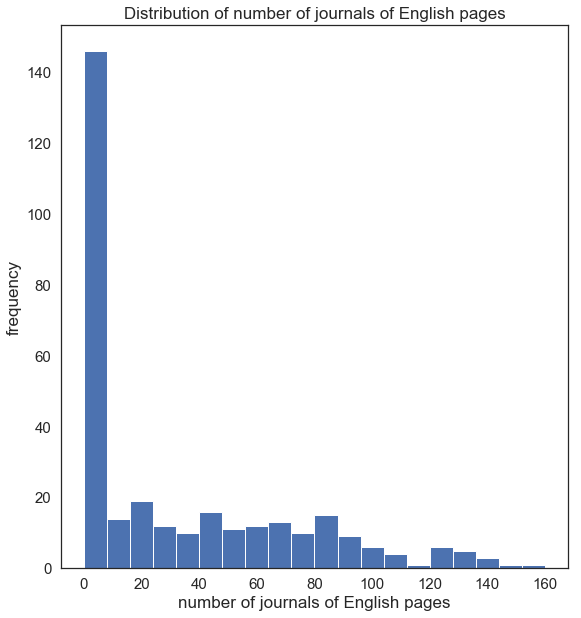

In [286]:
plt.subplot(1, 2, 1)
(keywords_n_journals_df.en_n_journals).plot.hist(bins=20, figsize=(20,10), edgecolor='white',range=[0,160])
plt.xlabel('number of journals of English pages', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Distribution of number of journals of English pages', fontsize=17)

Text(0.5, 1.0, 'Distribution of number of journals of Japanese pages')

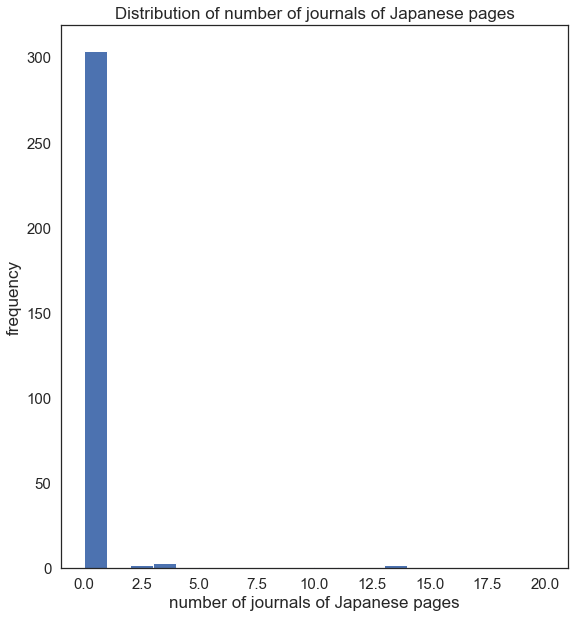

In [288]:
plt.subplot(1, 2, 1)
(keywords_n_journals_df.jp_n_journals).plot.hist(bins=20, figsize=(20,10), edgecolor='white',range=[0,20])
plt.xlabel('number of journals of Japanese pages', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Distribution of number of journals of Japanese pages', fontsize=17)

NameError: name 'keywords_n_journals_df' is not defined

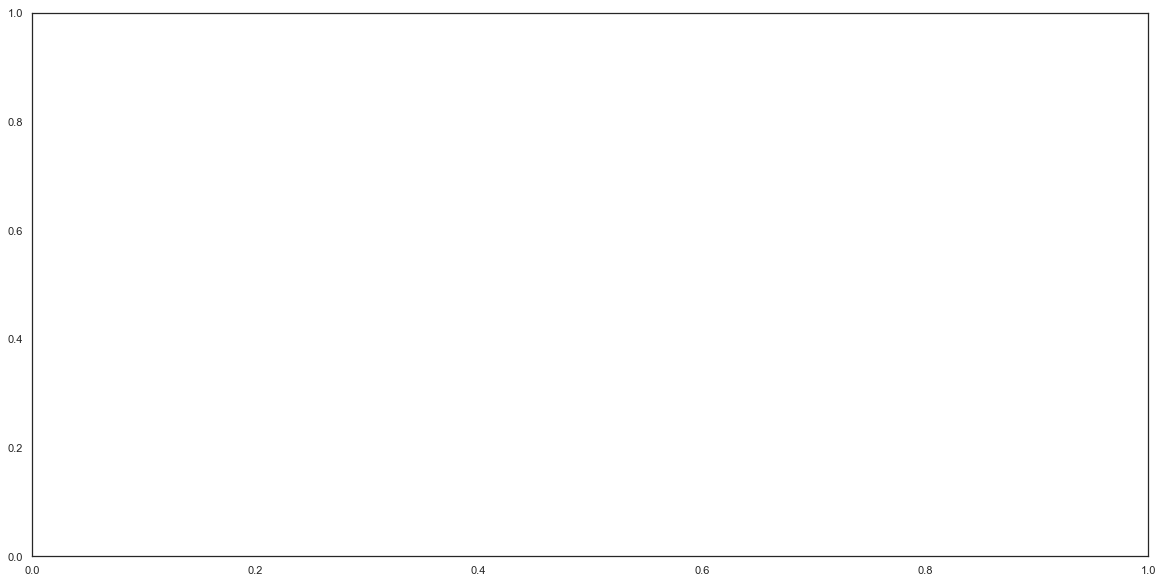

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
ax.hist(keywords_n_journals_df.jp_n_journals, color='#8CB4E1', alpha=0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(keywords_n_journals_df.en_n_journals, color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()

In [28]:
search_results_df

,rank,title,url,affiliate_url,paper_url
0,1,"Milk kefir: nutritional, microbiological and h...",https://www.cambridge.org/core/journals/nutrit...,,https://www.cambridge.org/about-us/legal-notic...
1,2,The Microbiota and Health Promoting Characteri...,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,,
2,3,"Milk kefir: composition, microbial cultures, b...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...,,
3,4,"Microbiological, technological and therapeutic...",https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,,
4,5,Short communication: Sensory analysis of a kef...,https://www.journalofdairyscience.org/article/...,,https://www.elsevier.com/journals/journal-of-d...
5,6,Biotechnological innovations in kefir producti...,https://www.emeraldinsight.com/doi/abs/10.1108...,,
6,7,Biotechnological innovations in kefir producti...,https://www.emeraldinsight.com/doi/full/10.110...,,
7,8,(PDF) Journal Dairy Research kefir 2011 - Rese...,https://www.researchgate.net/publication/25994...,,
8,9,Inhibitory Activity of Cheese Whey Fermented w...,https://jfoodprotection.org/doi/abs/10.4315/03...,,


In [10]:
en_master_df2 = pd.read_csv('./jp_master_df02.csv', index_col=0)
en_master_df2

,search_words,rank,title,url,affiliate_url,paper_url,n_affiliate_urls,n_paper_urls,html
0,アルコール飲料 健康,1,｢お酒は少量なら健康に良い｣はウソだった？ | 健康 | 東洋経済オンライン ...,https://toyokeizai.net/articles/-/235594,NaN,NaN,0,0,"<?xml version=""1.0"" encoding=""UTF-8""?>\n<!DOCT..."
1,アルコール飲料 健康,2,お酒がもたらす身体的なメリット｜人とお酒のイイ関係｜アサヒビール,https://www.asahibeer.co.jp/csr/tekisei/health...,NaN,NaN,0,0,"<!DOCTYPE html>\n\n<html lang=""ja"">\n<head>\n<..."
2,アルコール飲料 健康,3,飲酒の基礎知識 －公益社団法人アルコール健康医学協会－,http://www.arukenkyo.or.jp/health/base/index.html,NaN,NaN,0,0,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T..."
3,アルコール飲料 健康,4,「からだにいいアルコール」健康ランキングトップ10 | Laifu,http://laifu.jp/%25E4%25BD%2593%25E3%2581%258B...,NaN,NaN,0,0,"<!DOCTYPE html>\n\n<html class=""no-js"" lang=""j..."
4,アルコール飲料 健康,5,適正飲酒のすすめ | 知っておこう！上手な飲み方、付き合い方 | サッポロ ...,http://www.sapporobeer.jp/tekisei/kenkou/susum...,NaN,NaN,0,0,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T..."
5,アルコール飲料 健康,6,適量ってどのくらい？｜DRINK SMART お酒の正しい付き合い方を考え ...,https://www.suntory.co.jp/arp/proper_quantitiy/,NaN,NaN,0,0,"<!DOCTYPE html>\n\n<html lang=""ja"">\n<head>\n<..."
6,アルコール飲料 健康,7,アルコールと健康の関係は？ 「酒は百薬の長」は本当か | ニュース | 保健 ...,http://tokuteikenshin-hokensidou.jp/news/2014/...,NaN,NaN,0,0,"<!DOCTYPE html>\n\n<html lang=""ja"">\n<head pre..."
7,アルコール飲料 健康,8,「アルコールは少量でも健康に悪い」がんのリスクの可能性も ...,http://news.livedoor.com/article/detail/15241944/,NaN,NaN,0,0,"\n<!DOCTYPE html>\n\n<html lang=""ja"" xmlns:og=..."
8,アルコール飲料 健康,9,【健康】適量で長寿？でも脳は萎縮？飲酒のメリットとデメリット - NAVER ...,https://matome.naver.jp/odai/2141083627403854901,NaN,NaN,0,0,NaN
9,ビール 健康,1,「病気知らず」の体をつくるビール健康法 | TABI LABO,https://tabi-labo.com/288197/beer-health2,https://www.amazon.co.jp/dp/4344972503\nhttps:...,NaN,3,0,"<!DOCTYPE html>\n<html><head><meta charset=""ut..."
